In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
import seaborn as sn
import pandas as pd

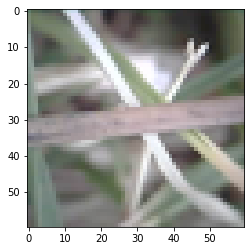

In [10]:
RAW_DIR = 'lab datasets'

CLASSES = []
for subdir in os.listdir(RAW_DIR):
    CLASSES.append(subdir)
    
images = []
for c in CLASSES:
    class_path = os.path.join(RAW_DIR, c)
    for file in os.listdir(class_path):
        file_path = os.path.join(class_path, file)
        
        img = Image.open(file_path).resize((60, 60))
        images.append(np.asarray(img).astype(np.float32) / 255.)

random.shuffle(images)
images = np.asarray(images)
plt.imshow(images[0])

In [11]:
model_name = 'labtest'

model = tf.keras.models.load_model('trained_models/' + model_name)
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 60, 60, 16)        448       
                                                                 
 batch_normalization_60 (Bat  (None, 60, 60, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 30, 30, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 30, 30, 16)        2320      
                                                                 
 batch_normalization_61 (Bat  (None, 30, 30, 16)       64        
 chNormalization)                                                
                                                     

In [12]:
quantize_path = f'./quantized_models/{model_name}.tflite'

def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
tflite_model = converter.convert()
tflite_model_size = open(quantize_path, "wb").write(tflite_model)
print("Quantized model is %d bytes" % tflite_model_size)

INFO:tensorflow:Assets written to: C:\Users\flami\AppData\Local\Temp\tmp5_r04hu6\assets


INFO:tensorflow:Assets written to: C:\Users\flami\AppData\Local\Temp\tmp5_r04hu6\assets
C:\Users\flami\miniconda3\envs\tf\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Quantized model is 42592 bytes


In [13]:
interpreter = tf.lite.Interpreter(model_path=quantize_path)
interpreter.allocate_tensors()

print("== Input details ==")
print("name:", interpreter.get_input_details()[0]['name'])
print("shape:", interpreter.get_input_details()[0]['shape'])
print("type:", interpreter.get_input_details()[0]['dtype'])

print("\n== Output details ==")
print("name:", interpreter.get_output_details()[0]['name'])
print("shape:", interpreter.get_output_details()[0]['shape'])
print("type:", interpreter.get_output_details()[0]['dtype'])

print("\nDUMP INPUT")
print(interpreter.get_input_details()[0])
print("\nDUMP OUTPUT")
print(interpreter.get_output_details()[0])

== Input details ==
name: serving_default_input_13:0
shape: [ 1 60 60  3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [1 5]
type: <class 'numpy.float32'>

DUMP INPUT
{'name': 'serving_default_input_13:0', 'index': 0, 'shape': array([ 1, 60, 60,  3]), 'shape_signature': array([-1, 60, 60,  3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}

DUMP OUTPUT
{'name': 'StatefulPartitionedCall:0', 'index': 54, 'shape': array([1, 5]), 'shape_signature': array([-1,  5]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
